# Lesson 2 - Working with Images and Logistic Regression

Bu ders, MNIST veri kümesindeki görüntülerle nasıl çalışılacağını, aşırı uyumu önlemek için eğitim ve doğrulama veri kümelerinin nasıl oluşturulacağını ve softmax etkinleştirmesini ve çapraz entropi kaybını kullanarak bir lojistik regresyon modelini eğitmeyi kapsar

Cuda == GPU, çok daha hızlı, ancak VRAM'in boyutuyla sınırlı

Cpu == CPU, daha yavaş, ancak genellikle daha fazla veri kullanabilir (RAM / sanal bellek ile sınırlıdır)



 
 
### Bu eğitim aşağıdaki konuları kapsar

-PyTorch'ta görüntülerle çalışma (MNIST veri kümesini kullanarak)

-Veri kümesini eğitim, doğrulama ve test kümelerine bölme

-Nn.Module sınıfını genişleterek özel mantıkla PyTorch modelleri oluşturma

-Softmax kullanarak model çıktılarını olasılıklar olarak yorumlama ve tahmin edilen etiketleri seçme

-Sınıflandırma problemleri için yararlı bir değerlendirme ölçüsü (doğruluk) ve kayıp işlevi (çapraz entropi) seçme

-Doğrulama kümesini kullanarak modeli de değerlendiren bir eğitim döngüsü kurma

-Modeli rastgele seçilen örnekler üzerinde manuel olarak test etme

-Sıfırdan yeniden eğitimden kaçınmak için model kontrol noktalarını kaydetme ve yükleme

## Working with Images


Bu eğitimde, çok farklı türde bir sorunu çözmek için mevcut PyTorch bilgimizi ve doğrusal regresyonu kullanacağız: görüntü sınıflandırması. Eğitim veri setimiz olarak ünlü MNIST Handwritten Digits Veritabanını kullanacağız. El yazısı rakamların (0 - 9) 28px 28px gri tonlamalı görüntülerinden ve her görüntü için hangi basamağı temsil ettiğini belirten etiketlerden oluşur. Veri kümesinden bazı örnek görüntüler şunlardır:

torch ve torchvision import ederek başlıyoruz. Torchvision, görüntü verileriyle çalışmak için bazı yardımcı programlar içerir. Ayrıca, MNIST gibi popüler veri kümelerini otomatik olarak indirmek ve içe aktarmak için yardımcı sınıflar sağlar

In [1]:
import torch
import torchvision
from torchvision.datasets import MNIST
from torchvision.datasets import CIFAR10
from torch.utils.data import random_split, DataLoader

In [2]:
dataset = MNIST(root='data/', download=True)
len(dataset)

60000

In [3]:
test_dataset = MNIST(root='data/', train=False)
len(test_dataset)

10000

In [4]:
#Let's look at a sample element from the training dataset.
dataset[0]

(<PIL.Image.Image image mode=L size=28x28 at 0x1FC3DBFA808>, 5)

28x28 piksel boyutunda bir resim ve bir etiketten oluşan bir çift. Resim, Python görüntüleme kütüphanesi Pillow'un bir parçası olan PIL.Image.Image sınıfının bir nesnesidir. Python'da veri bilimi için fiili çizim ve grafik kitaplığı olan matplotlib'i kullanarak Jupyter içindeki görüntüyü görüntüleyebiliriz.

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

% Matplotlib inline ifadesi, Jupyter'e not defterinin içindeki grafikleri çizmek istediğimizi belirtir. Bu satır olmadan, Jupyter resmi bir açılır pencerede gösterecektir. % İle başlayan ifadeler sihirli komutlar olarak adlandırılır ve Jupyter'in kendi davranışını yapılandırmak için kullanılır. Sihirli komutların tam listesini burada bulabilirsiniz: https://ipython.readthedocs.io/en/stable/interactive/magics.html.

Veri kümesinden birkaç resme bakalım.

Label: 5


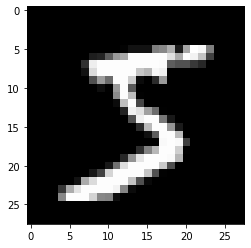

In [6]:
image, label = dataset[0]
plt.imshow(image, cmap='gray')
print('Label:', label)

Label: 3


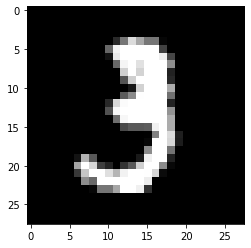

In [7]:
image, label = dataset[10]
plt.imshow(image, cmap='gray')
print('Label:', label)

Bu görüntülerin nispeten küçük olduğu açıktır ve rakamları tanımak bazen insan gözü için bile zor olabilir. Bu resimlere bakmak faydalı olsa da, burada sadece bir sorun var: PyTorch resimlerle nasıl çalışılacağını bilmiyor. Görüntüleri tensöre çevirmemiz gerekiyor. Bunu, veri setimizi oluştururken bir dönüşüm belirleyerek yapabiliriz.

In [8]:
import torchvision.transforms as transforms

PyTorch veri kümeleri, yüklenirken görüntülere uygulanan bir veya daha fazla dönüştürme işlevi belirlememize olanak tanır. Torchvision.transforms modülü, bu tür önceden tanımlanmış birçok işlevi içerir. Görüntüleri PyTorch tensörlerine dönüştürmek için ToTensor dönüşümünü kullanacağız.

Dönüşüm için transformdan ToTensor  kullanılır

In [9]:
dataset = MNIST(root = 'data/', train = True, transform = transforms.ToTensor())

In [10]:
img_tensor, label = dataset[0]
print(img_tensor.shape, label)

torch.Size([1, 28, 28]) 5



Görüntü şimdi 1x28x28 tensöre dönüştürülür. İlk boyut, renk kanallarını izler. İkinci ve üçüncü boyutlar, sırasıyla görüntünün yüksekliği ve genişliği boyunca pikselleri temsil eder. MNIST veri kümesindeki görüntüler gri tonlamalı olduğundan, yalnızca bir kanal vardır. Diğer veri kümelerinin renkli görüntüleri vardır, bu durumda üç kanal vardır: kırmızı, yeşil ve mavi (RGB).

Tensörün içindeki bazı örnek değerlere bakalım.

In [11]:
img_tensor[0, 5:10, 5:10]

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.1176, 0.1412],
        [0.0000, 0.0000, 0.1922, 0.9333, 0.9922],
        [0.0000, 0.0000, 0.0706, 0.8588, 0.9922],
        [0.0000, 0.0000, 0.0000, 0.3137, 0.6118]])

In [12]:
print("max:",img_tensor.max(),"\nmin:",img_tensor.min())

max: tensor(1.) 
min: tensor(0.)


Değerler 0 ile 1 arasındadır; 0 siyahı, 1 beyazı temsil eder ve değerler grinin farklı tonları arasındaki değerlerdedir. Tensörü plt.imshow kullanarak bir görüntü olarak da çizebiliriz.

In [13]:
litle_part = img_tensor[0, 5:15, 5:15]

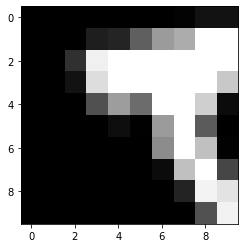

In [14]:
plt.imshow(litle_part, cmap = 'gray');

In [15]:
## Traing and Validation Datasets (Eğitim ve Doğrulama Veri Kümeleri)

Gerçek dünya makine öğrenimi modelleri oluştururken, veri kümesini üç bölüme ayırmak oldukça yaygındır:
 
1-)Train seti - modeli eğitmek, yani kaybı hesaplamak ve gradyan inişini kullanarak modelin ağırlıklarını ayarlamak için kullanılır.

2-)Validation seti - eğitim sırasında modeli değerlendirmek, hiper parametreleri ayarlamak (öğrenme oranı vb.) Ve modelin en iyi sürümünü seçmek için kullanılır.

3-)Test seti - farklı modelleri veya yaklaşımları karşılaştırmak ve modelin nihai doğruluğunu raporlamak için kullanılır.

MNIST veri kümesinde 60.000 eğitim görüntüsü ve 10.000 test görüntüsü vardır. Test seti, farklı araştırmacıların modellerinin sonuçlarını aynı görüntü koleksiyonuna göre raporlayabilmeleri için standartlaştırılmıştır.

Önceden tanımlanmış bir doğrulama seti olmadığından, 60.000 görüntüyü eğitim ve doğrulama veri kümelerine manuel olarak bölmeliyiz. Doğrulama için rastgele seçilen 10.000 resmi bir kenara bırakalım. Bunu PyTorch'un random_spilt yöntemini kullanarak yapabiliriz.

In [16]:
train_ds, valid_ds = random_split(dataset, [50000,10000])

In [17]:
len(valid_ds)

10000

Bir doğrulama seti oluşturmak için rastgele bir örnek seçmek önemlidir. Eğitim verileri genellikle hedef etiketlere göre sıralanır, yani 0'ların resimleri, ardından 1'ler, ardından 2'ler vb. Görüntülerin son %20'sini kullanarak bir doğrulama kümesi oluşturursak, yalnızca 8 ve 9'lardan oluşur. Aksine, eğitim seti 8 veya 9 içermez. Böyle bir eğitim-doğrulama, faydalı bir modelin eğitilmesini imkansız kılacaktır.

Artık verileri gruplar halinde yüklememize yardımcı olmak için dataloader oluşturabiliriz. 128 toplu iş boyutu kullanacağız

Dataloader. Bir veri kümesini ve bir örnekleyiciyi birleştirir ve verilen veri kümesi üzerinde yinelenebilirlik sağlar. 

In [18]:
batch_size = 128

train_loader = DataLoader(train_ds, batch_size, shuffle = True)
valid_loader = DataLoader(valid_ds, batch_size)

Her epochta üretilen grup (yığın) farklı olmasını sağlamak için train Dataloader için shuffle = True ayarını yaptık. Bu randomizasyon, eğitim sürecini genelleştirmeye ve hızlandırmaya yardımcı olur. Öte yandan, validation Dataloader yalnızca modeli değerlendirmek için kullanıldığından, görüntüleri karıştırmaya gerek yoktur.

## Model

### Veri yükleyicilerimizi hazırladığımıza göre artık modelimizi tanımlayabiliriz.

-Lojistik regresyon modeli, doğrusal regresyon modeliyle neredeyse aynıdır. Ağırlıkları ve sapma matrislerini içerir ve çıktı, basit matris işlemleri kullanılarak elde edilir (pred = x @ w.t () + b).

-Doğrusal regresyonda yaptığımız gibi, matrisleri manuel olarak oluşturmak ve başlatmak yerine modeli oluşturmak için nn.Linear'ı kullanabiliriz.

-Nn.Linear, her eğitim örneğinin bir vektör olmasını beklediğinden, her bir 1x28x28 görüntü tensörü, modele geçirilmeden önce 784 (28 * 28) boyutunda bir vektöre düzleştirilir.

-Her bir görüntünün çıktısı, her bir öğenin belirli bir hedef etiketin olasılığını (yani, 0 ila 9) ifade ettiği 10 boyutlu bir vektördür. Bir görüntü için tahmin edilen etiket, en yüksek olasılığa sahip olandır.

In [19]:
import torch.nn as nn

In [20]:
input_size = 28*28 #resimler 28*28 boyutta olduğundan
num_classes = 10

In [21]:
#Logistic regression model
model = nn.Linear(input_size, num_classes)# ilki input ikincisi output

In [22]:
print(model.weight.size())
model.weight

torch.Size([10, 784])


Parameter containing:
tensor([[-1.3769e-03,  8.3551e-03,  3.1395e-02,  ...,  1.9739e-03,
         -3.4000e-02, -3.6271e-03],
        [ 3.3000e-03,  1.0442e-03, -1.0191e-02,  ...,  3.5161e-02,
          1.0778e-02,  2.8377e-02],
        [ 1.4389e-02,  2.0838e-02,  2.4912e-02,  ..., -1.0750e-03,
         -7.0434e-03, -1.4489e-02],
        ...,
        [-2.4445e-02,  1.0576e-02, -3.4993e-02,  ...,  3.4030e-02,
          2.2724e-02,  1.2206e-03],
        [ 8.1509e-03, -3.4869e-02,  3.5674e-02,  ...,  3.5121e-02,
         -1.7276e-02, -8.2927e-03],
        [ 1.0474e-02,  9.5362e-03,  1.7759e-02,  ..., -2.5172e-02,
          5.4352e-05,  2.5477e-02]], requires_grad=True)

In [23]:
print(model.bias.shape)
model.bias

torch.Size([10])


Parameter containing:
tensor([ 0.0010,  0.0034, -0.0229, -0.0093,  0.0024,  0.0324,  0.0342,  0.0048,
        -0.0134,  0.0063], requires_grad=True)

Burada toplam 7850 parametre olmasına rağmen kavramsal olarak şimdiye kadar hiçbir şey değişmedi. Modelimizi kullanarak bazı çıktılar oluşturmaya çalışalım. Veri kümemizden ilk 100 görüntü grubunu alıp modelimize aktaracağız

In [24]:
for images, labels in train_loader:
    print(labels)
    print(images.shape)
    outputs = model(images)
    print(outputs)
    break


tensor([3, 3, 4, 3, 6, 2, 9, 5, 7, 6, 5, 4, 7, 4, 2, 4, 4, 5, 4, 8, 4, 1, 0, 5,
        1, 4, 0, 5, 3, 7, 8, 6, 4, 6, 7, 7, 9, 2, 2, 9, 1, 4, 6, 8, 7, 8, 6, 9,
        0, 0, 5, 6, 5, 2, 2, 8, 0, 6, 6, 9, 1, 5, 7, 9, 0, 6, 7, 6, 3, 4, 6, 9,
        9, 1, 8, 0, 4, 3, 0, 7, 7, 9, 5, 2, 8, 0, 4, 2, 4, 4, 5, 5, 1, 3, 5, 3,
        1, 1, 9, 5, 5, 9, 5, 5, 6, 4, 1, 1, 1, 8, 4, 9, 8, 3, 3, 2, 0, 0, 8, 3,
        3, 1, 4, 0, 0, 2, 0, 1])
torch.Size([128, 1, 28, 28])


RuntimeError: mat1 and mat2 shapes cannot be multiplied (3584x28 and 784x10)

In [25]:
images.shape

torch.Size([128, 1, 28, 28])

In [26]:
images.reshape(128,784).shape

torch.Size([128, 784])

Yukarıdaki kod, girdi verilerimiz doğru şekle sahip olmadığı için bir hataya yol açar. Resimlerimiz 1x28x28 şeklindedir, ancak bunların 784 boyutunda vektörler olmasına ihtiyacımız var, yani onları düzleştirmemiz gerekiyor. Tensörün .reshape yöntemini kullanacağız, bu da her bir görüntüyü, temeldeki verilerin bir kopyasını gerçekten oluşturmadan düz bir vektör olarak verimli bir şekilde 'görüntülememize' izin verecek. Bu ek işlevselliği modelimize dahil etmek için, PyTorch'tan nn.Module sınıfını genişleterek özel bir model tanımlamamız gerekir.

Python'daki bir sınıf, nesneler oluşturmak için bir 'blueprint' sağlar. Python'da yeni bir sınıf tanımlamanın bir örneğine bakalım.

In [27]:
class MnistModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(input_size, num_classes)
        
    def forward(self, xb):
        xb = xb.reshape(-1, 784)
        out = self.linear(xb)
        return out
    
model = MnistModel()


__İnit__ yapıcı yönteminin içinde, nn.Linear kullanarak ağırlıkları ve önyargıları somutlaştırıyoruz. Ve modele bir grup girdi ilettiğimizde çağrılan ileri yöntemde, girdi tensörünü düzleştiririz ve self.linear'a geçiririz.

Xb.reshape (-1, 28 * 28), PyTorch'a xb tensörünün iki boyutlu bir görünümünü istediğimizi belirtir. 2. boyut boyunca uzunluk 28 * 28'dir (yani 784). .Reshape için bir argüman, PyTorch'un orijinal tensörün şekline göre otomatik olarak anlamasına izin vermek için -1'e (bu durumda, ilk boyut) ayarlanabilir.

Modelin artık .weight ve .bias özniteliklerine sahip olmadığını unutmayın (artık .linear özniteliğinin içindeler), ancak ağırlıkları ve önyargıları içeren bir liste döndüren bir .parameters yöntemine sahip olduğunu unutmayın.

In [28]:
#artık model.bias yerine model.linear.bias şeklinde weight ile biasa bakıcaz

In [29]:
model.linear

Linear(in_features=784, out_features=10, bias=True)

In [30]:
model.linear.bias

Parameter containing:
tensor([ 0.0067, -0.0016, -0.0051, -0.0267,  0.0234,  0.0332,  0.0119,  0.0170,
         0.0243, -0.0148], requires_grad=True)

In [31]:
model.linear.weight

Parameter containing:
tensor([[-0.0196, -0.0042, -0.0332,  ...,  0.0015, -0.0081,  0.0107],
        [-0.0052, -0.0250, -0.0108,  ..., -0.0157,  0.0111, -0.0061],
        [ 0.0095, -0.0053,  0.0219,  ...,  0.0035, -0.0352, -0.0145],
        ...,
        [ 0.0292, -0.0050,  0.0111,  ...,  0.0229, -0.0132, -0.0097],
        [ 0.0011,  0.0167, -0.0291,  ..., -0.0202,  0.0169,  0.0056],
        [-0.0330,  0.0064,  0.0122,  ..., -0.0112, -0.0289,  0.0021]],
       requires_grad=True)

Yeni özel modelimizi eskisi gibi kullanabiliriz. İşe yarayıp yaramadığını görelim.

In [32]:
for images, labels in train_loader:
    print(images.shape)
    outputs = model(images)
    break

print('outputs.shape : ', outputs.shape)
print('Sample outputs :\n', outputs[:1].data)#bu değerler bizim train loader içindeki grubumuzun çıktılarıdır

torch.Size([128, 1, 28, 28])
outputs.shape :  torch.Size([128, 10])
Sample outputs :
 tensor([[-0.0118, -0.0254, -0.0961, -0.0448,  0.2052, -0.0595,  0.0211,  0.1797,
          0.0230,  0.0800]])


 
100 input görüntüsünün her biri için, her sınıf için bir tane olmak üzere 10 output elde ederiz. Daha önce tartışıldığı gibi, bu çıktıların olasılıkları temsil etmesini istiyoruz. Her çıktı satırının öğeleri 0 ile 1 arasında olmalı ve toplamı 1 olmalıdır, bu durum böyle değildir.(eksili değerler bulunmaktadır)

Çıktı satırlarını olasılıklara dönüştürmek için aşağıdaki formüle sahip softmax fonksiyonunu kullanıyoruz:


İlk olarak, bir çıktı satırındaki her yi öğesini e^yi ile değiştirerek tüm öğeleri pozitif yaparız.

Daha sonra, toplamlarının 1'e ulaşmasını sağlamak için onları toplamlarına böleriz. Elde edilen vektör böylece olasılıklar olarak yorumlanabilir.

Softmax işlevini uygulamak kolay olsa da (denemelisiniz!), PyTorch içinde sağlanan uygulamayı kullanacağız çünkü çok boyutlu tensörlerle iyi çalışıyor (bizim durumumuzda çıktı satırlarının bir listesi).

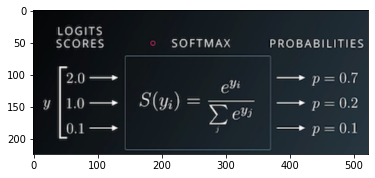

In [33]:
import matplotlib.image as mpimg
img = mpimg.imread('foto\softmax.png')
plt.imshow(img)

Softmax işlevi, torch.nn. İşlevsel paketine dahildir ve işlevin uygulanması gereken bir boyut belirlememizi gerektirir.

In [34]:
import torch.nn.functional as F

In [35]:
outputs[:2]

tensor([[-0.0118, -0.0254, -0.0961, -0.0448,  0.2052, -0.0595,  0.0211,  0.1797,
          0.0230,  0.0800],
        [-0.0442,  0.0044,  0.3965, -0.2208,  0.2091, -0.1097, -0.0585, -0.1684,
          0.1676,  0.0726]], grad_fn=<SliceBackward>)

In [36]:
# Her çıktı satırı için softmax uygulayın
probs = F.softmax(outputs, dim = 1)

In [37]:
# Örnek olasılıklara bakın
print("Sample probabilities:\n", probs[:2].data)

Sample probabilities:
 tensor([[0.0957, 0.0944, 0.0880, 0.0926, 0.1189, 0.0913, 0.0989, 0.1159, 0.0991,
         0.1049],
        [0.0918, 0.0964, 0.1426, 0.0769, 0.1182, 0.0860, 0.0905, 0.0811, 0.1134,
         0.1032]])


In [38]:
# Örnek olasılıklara bakın
print("sum:",probs[0].data.sum().item())
#veya
print("Sum: ",torch.sum(probs[0]).item())

sum: 1.0
Sum:  1.0


Son olarak, her bir çıktı satırında en yüksek olasılığa sahip öğenin dizinini seçerek her bir görüntü için tahmin edilen etiketi belirleyebiliriz. Bunu, her satırın en büyük elemanını ve karşılık gelen dizini döndüren torch.max kullanarak yapabiliriz.

-dim = 0 sütunsal işlemler 

-dim = 1 satırsal işlemler

In [39]:
max_props, preds = torch.max(probs, dim = 1)
print(max_props)
print("tahmin değerleri")
print(preds)

tensor([0.1189, 0.1426, 0.1183, 0.1347, 0.1453, 0.1269, 0.1389, 0.1246, 0.1407,
        0.1401, 0.1556, 0.1210, 0.1296, 0.1410, 0.1195, 0.1193, 0.1379, 0.1329,
        0.1266, 0.1387, 0.1463, 0.1400, 0.1252, 0.1431, 0.1272, 0.1272, 0.1603,
        0.1309, 0.1431, 0.1314, 0.1192, 0.1345, 0.1173, 0.1238, 0.1381, 0.1355,
        0.1289, 0.1129, 0.1283, 0.1458, 0.1297, 0.1182, 0.1546, 0.1289, 0.1146,
        0.1222, 0.1249, 0.1206, 0.1263, 0.1356, 0.1298, 0.1200, 0.1654, 0.1317,
        0.1303, 0.1287, 0.1254, 0.1251, 0.1486, 0.1243, 0.1296, 0.1254, 0.1321,
        0.1158, 0.1278, 0.1294, 0.1700, 0.1311, 0.1320, 0.1330, 0.1290, 0.1274,
        0.1290, 0.1387, 0.1407, 0.1196, 0.1386, 0.1229, 0.1255, 0.1194, 0.1207,
        0.1386, 0.1315, 0.1361, 0.1420, 0.1343, 0.1262, 0.1146, 0.1264, 0.1299,
        0.1539, 0.1461, 0.1154, 0.1308, 0.1198, 0.1128, 0.1544, 0.1317, 0.1427,
        0.1286, 0.1267, 0.1475, 0.1210, 0.1452, 0.1202, 0.1427, 0.1214, 0.1371,
        0.1210, 0.1579, 0.1213, 0.1302, 

In [40]:
print(labels)

tensor([9, 2, 9, 4, 4, 7, 1, 0, 4, 9, 9, 3, 0, 8, 5, 2, 7, 4, 9, 6, 2, 3, 9, 7,
        4, 9, 8, 4, 9, 4, 4, 0, 1, 4, 2, 8, 6, 1, 8, 2, 2, 1, 7, 3, 2, 6, 9, 3,
        9, 5, 2, 4, 6, 5, 5, 4, 4, 7, 5, 9, 7, 1, 5, 2, 5, 4, 8, 7, 0, 6, 9, 3,
        6, 8, 3, 1, 7, 1, 1, 1, 6, 6, 6, 4, 3, 4, 1, 1, 3, 0, 3, 2, 7, 3, 1, 6,
        3, 4, 4, 1, 6, 7, 0, 3, 8, 2, 3, 3, 7, 8, 4, 4, 9, 2, 7, 2, 9, 1, 5, 1,
        9, 1, 2, 6, 7, 4, 6, 4])


Tahmin edilen etiketlerin çoğu gerçek etiketlerden farklıdır. Bunun nedeni, rastgele başlatılmış ağırlıklar ve önyargılarla başlamış olmamızdır. Modeli eğitmemiz gerekiyor, yani daha iyi tahminler yapmak için ağırlıkları gradyan inişi kullanarak ayarlamamız gerekiyor.

## Evaluation Metric and Loss Function

Doğrusal regresyonda olduğu gibi, modelimizin ne kadar iyi performans gösterdiğini değerlendirmenin bir yoluna ihtiyacımız var. Bunu yapmanın doğal bir yolu, doğru tahmin edilen etiketlerin yüzdesini bulmaktır, yani. Tahminlerin doğruluğu.

In [41]:
outputs[:2]

tensor([[-0.0118, -0.0254, -0.0961, -0.0448,  0.2052, -0.0595,  0.0211,  0.1797,
          0.0230,  0.0800],
        [-0.0442,  0.0044,  0.3965, -0.2208,  0.2091, -0.1097, -0.0585, -0.1684,
          0.1676,  0.0726]], grad_fn=<SliceBackward>)

In [42]:
torch.sum(preds == labels)

tensor(13)


== operatörü, aynı şekle sahip iki tensörün öğe bazında karşılaştırmasını gerçekleştirir ve eşit olmayan öğeler için True ve eşit öğeler için False içeren aynı şekle sahip bir tensör döndürür. Sonucu torch.sum'a iletmek, doğru tahmin edilen etiket sayısını döndürür. Son olarak, doğruluğu elde etmek için toplam görüntü sayısına böleriz.

Sonuçların aynı göreceli sıraya sahip olması nedeniyle çıktılara softmax uygulamamıza gerek olmadığını unutmayın. Bunun nedeni, e ~ x'in artan bir fonksiyon olmasıdır, yani eğer y1 y2 ise, e ~ y1 e ~ y2. Aynı şey, softmax'ı elde etmek için değerlerin ortalamasını aldıktan sonra da geçerlidir.

Mevcut modelin doğruluğunu ilk veri grubu üzerinde hesaplayalım.

In [43]:
torch.max(outputs, dim=1)

torch.return_types.max(
values=tensor([0.2052, 0.3965, 0.1751, 0.2675, 0.3403, 0.1404, 0.3336, 0.2705, 0.4087,
        0.4127, 0.5186, 0.2585, 0.2054, 0.3519, 0.2010, 0.1387, 0.3306, 0.2813,
        0.1599, 0.3391, 0.3097, 0.3621, 0.2416, 0.4355, 0.2466, 0.2798, 0.4856,
        0.2883, 0.4503, 0.3162, 0.2077, 0.3082, 0.2442, 0.2199, 0.3420, 0.2814,
        0.2589, 0.2263, 0.3085, 0.2904, 0.2151, 0.2232, 0.4060, 0.2095, 0.1445,
        0.2071, 0.2373, 0.1948, 0.2638, 0.3244, 0.3329, 0.2200, 0.5878, 0.3513,
        0.1619, 0.2544, 0.1993, 0.2094, 0.4298, 0.1872, 0.3241, 0.2964, 0.2648,
        0.0679, 0.3337, 0.3821, 0.5452, 0.3034, 0.2335, 0.2477, 0.2487, 0.2430,
        0.2588, 0.3060, 0.3661, 0.2484, 0.2831, 0.2517, 0.2829, 0.2601, 0.1768,
        0.2454, 0.2385, 0.3097, 0.2982, 0.2850, 0.3126, 0.2279, 0.1895, 0.2754,
        0.4487, 0.3707, 0.0949, 0.2143, 0.2275, 0.1610, 0.4750, 0.2845, 0.4081,
        0.3023, 0.2607, 0.4642, 0.1989, 0.3851, 0.1963, 0.4300, 0.2178, 0.2311,
        0

In [44]:
def accurcy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [45]:
torch.sum(preds == labels).item()

13

In [46]:
accurcy(outputs, labels)

tensor(0.1016)

Doğruluk, bizler (insanlar) için modeli değerlendirmenin mükemmel bir yoludur. Ancak, aşağıdaki nedenlerle gradyan inişini kullanarak modelimizi optimize etmek için bir kayıp fonksiyonu olarak kullanamayız:

---1-)Türevlenebilir bir işlev değil. Torch.max ve == hem sürekli olmayan hem de farklılaştırılamayan işlemlerdir, bu nedenle, ağırlık ve önyargılarla gradyanları hesaplarken doğruluğu kullanamayız.

---2-)Model tarafından tahmin edilen gerçek olasılıkları hesaba katmaz, bu nedenle artan iyileştirmeler için yeterli geri bildirim sağlayamaz.

Bu nedenlerden dolayı, doğruluk genellikle sınıflandırma için bir değerlendirme ölçütü olarak kullanılır, ancak bir kayıp işlevi olarak kullanılmaz. Sınıflandırma problemleri için yaygın olarak kullanılan bir kayıp fonksiyonu, aşağıdaki formüle sahip olan çapraz entropidir:

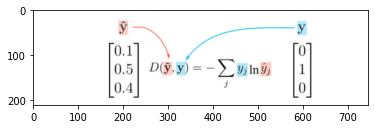

In [47]:
img1 = mpimg.imread('foto\lossentropi.png')
plt.imshow(img1)

Karmaşık görünse de aslında oldukça basit:

---Her çıktı satırı için, doğru etiket için tahmin edilen olasılığı seçin. Örneğin, bir görüntü için tahmin edilen olasılıklar [0,1, 0,3, 0,2, ...] ve doğru etiket 1 ise, karşılık gelen öğe 0,3'ü seçer ve gerisini göz ardı ederiz.

---Ardından, seçilen olasılığın logaritmasını alın. Olasılık yüksekse, yani 1'e yakınsa, logaritması çok küçük bir negatif değerdir, 0'a yakındır. Ve olasılık düşükse (0'a yakın), o zaman logaritma çok büyük bir negatif değerdir. Ayrıca sonucu -1 ile çarpıyoruz, bu da kötü tahminler için büyük bir pozitif değer kaybıdır.

---Son olarak, bir veri yığını için genel kaybı elde etmek için tüm çıktı satırlarındaki çapraz entropinin ortalamasını alın.
Doğruluktan farklı olarak, çapraz entropi sürekli ve farklılaştırılabilir bir işlevdir. Ayrıca, modeldeki aşamalı iyileştirmeler için yararlı geri bildirim sağlar (doğru etiket için biraz daha yüksek olasılık, daha düşük bir kayba yol açar). Bu iki faktör, çapraz entropiyi kayıp işlevi için daha iyi bir seçim haline getirir.

Tahmin edebileceğiniz gibi PyTorch, torch.nn. Fonksiyonel paketin bir parçası olarak çapraz entropinin verimli ve tensör dostu bir uygulamasını sağlar. Dahası, dahili olarak softmax da gerçekleştirir, böylece modelin çıktılarını olasılıklara dönüştürmeden doğrudan aktarabiliriz.

In [48]:
outputs

tensor([[-1.1794e-02, -2.5423e-02, -9.6066e-02,  ...,  1.7972e-01,
          2.2995e-02,  7.9960e-02],
        [-4.4195e-02,  4.4328e-03,  3.9649e-01,  ..., -1.6836e-01,
          1.6765e-01,  7.2636e-02],
        [-4.8215e-02, -1.0000e-01,  5.1581e-02,  ...,  1.0398e-01,
         -4.0650e-02, -1.0929e-01],
        ...,
        [ 1.2423e-01,  1.0456e-01, -9.5176e-02,  ..., -3.4136e-04,
         -1.4016e-03,  5.1257e-02],
        [-4.3595e-02, -3.4165e-01, -4.1758e-02,  ...,  1.9651e-01,
          9.9460e-02,  1.4404e-01],
        [ 1.3602e-02, -3.5640e-02,  1.5026e-01,  ...,  8.1945e-02,
          8.8952e-02,  2.5610e-02]], grad_fn=<AddmmBackward>)

In [49]:
loss_fn = F.cross_entropy

In [50]:
# Mevcut veri grubu kaybı
loss = loss_fn(outputs, labels)
loss

tensor(2.2923, grad_fn=<NllLossBackward>)

In [51]:
outputs#çıkış olasılıkları ile

tensor([[-1.1794e-02, -2.5423e-02, -9.6066e-02,  ...,  1.7972e-01,
          2.2995e-02,  7.9960e-02],
        [-4.4195e-02,  4.4328e-03,  3.9649e-01,  ..., -1.6836e-01,
          1.6765e-01,  7.2636e-02],
        [-4.8215e-02, -1.0000e-01,  5.1581e-02,  ...,  1.0398e-01,
         -4.0650e-02, -1.0929e-01],
        ...,
        [ 1.2423e-01,  1.0456e-01, -9.5176e-02,  ..., -3.4136e-04,
         -1.4016e-03,  5.1257e-02],
        [-4.3595e-02, -3.4165e-01, -4.1758e-02,  ...,  1.9651e-01,
          9.9460e-02,  1.4404e-01],
        [ 1.3602e-02, -3.5640e-02,  1.5026e-01,  ...,  8.1945e-02,
          8.8952e-02,  2.5610e-02]], grad_fn=<AddmmBackward>)

In [52]:
labels#çıktı tahminlerini cross entropiye yolluyoruz

tensor([9, 2, 9, 4, 4, 7, 1, 0, 4, 9, 9, 3, 0, 8, 5, 2, 7, 4, 9, 6, 2, 3, 9, 7,
        4, 9, 8, 4, 9, 4, 4, 0, 1, 4, 2, 8, 6, 1, 8, 2, 2, 1, 7, 3, 2, 6, 9, 3,
        9, 5, 2, 4, 6, 5, 5, 4, 4, 7, 5, 9, 7, 1, 5, 2, 5, 4, 8, 7, 0, 6, 9, 3,
        6, 8, 3, 1, 7, 1, 1, 1, 6, 6, 6, 4, 3, 4, 1, 1, 3, 0, 3, 2, 7, 3, 1, 6,
        3, 4, 4, 1, 6, 7, 0, 3, 8, 2, 3, 3, 7, 8, 4, 4, 9, 2, 7, 2, 9, 1, 5, 1,
        9, 1, 2, 6, 7, 4, 6, 4])

Çapraz entropinin, tüm eğitim örnekleri üzerinde ortalaması alınan doğru etiketin tahmin edilen olasılığının negatif logaritması olduğunu biliyoruz. Bu nedenle, ortaya çıkan sayıyı yorumlamanın bir yolu, ör. 2.23, ortalama olarak doğru etiketin tahmin edilen olasılığı 0.1 civarında olan e ~ -2.23'e bakın. Kayıp ne kadar düşükse, model o kadar iyi.

## Training the model

Veri yükleyicileri, modeli, kayıp fonksiyonunu ve optimize ediciyi tanımladığımıza göre, artık modeli eğitmeye hazırız. Eğitim süreci, her epochta modeli değerlendirmek için bir 'doğrulama aşaması' eklenmesiyle doğrusal regresyonla aynıdır. Sözde kodda şöyle görünüyor:

for epoch in range(num_epochs):
    # Training phase
    for batch in train_loader:
        # Generate predictions
        # Calculate loss
        # Compute gradients
        # Update weights
        # Reset gradients
    
    # Validation phase
    for batch in val_loader:
        # Generate predictions
        # Calculate loss
        # Calculate metrics (accuracy etc.)
    # Calculate average validation loss & metrics
    
    # Log epoch, loss & metrics for inspection

Eğitim döngüsünün bazı bölümleri, çözdüğümüz belirli soruna özeldir (örneğin, kayıp işlevi, ölçüler vb.), Diğerleri geneldir ve herhangi bir derin öğrenme problemine uygulanabilir. Sorundan bağımsız parçaları, modeli eğitmek için kullanılacak olan fit adlı bir işleve dahil edeceğiz. Soruna özgü parçalar, nn.Module sınıfına yeni yöntemler eklenerek uygulanacaktır.

In [53]:
def fit(epochs, lr, model, train_loader, validation_loader, opt_func = torch.optim.SGD):
    optimizer = opt_func(model.parameters(), lr)#optimizsayon neye yapılır ? weight ve bias'a    lr ne ? öğrenme katsayısı(learning rate)
    history = [] #epochlara göre sonuçları kaydetmek için
    for epoch in range(epochs):
        #iterasyon
        #train
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()#gradyan hesabı için
            optimizer.step()#weigth ve bias güncelleme
            optimizer.zero_grad()#her döngüde graadyan temizleme
        
        #validation
        result = evaluate(model, valid_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    
    return history

In [54]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

In [55]:
class MnistModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(input_size, num_classes)
        
    def forward(self, xb):
        xb = xb.reshape(-1, 784)
        out = self.linear(xb)
        return out
    
    def training_step(self, batch):
        images, labels = batch
        out = self(images)   
        loss = F.cross_entropy(out, labels)
        return loss
    
    def validation_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        acc = accurcy(out, labels)
        return {'val_loss': loss, 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean() 
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

In [56]:
model = MnistModel()

In [57]:
result0 = evaluate(model, valid_loader)  #başlangıçtaki başarı oranı ölçelim
result0

{'val_loss': 2.350987195968628, 'val_acc': 0.06665348261594772}

In [58]:
history1 = fit(5, 0.001, model, train_loader, valid_loader) 
history1#return result bizim evanın son halidir

Epoch [0], val_loss: 1.9777, val_acc: 0.6001
Epoch [1], val_loss: 1.7023, val_acc: 0.7284
Epoch [2], val_loss: 1.4959, val_acc: 0.7680
Epoch [3], val_loss: 1.3398, val_acc: 0.7889
Epoch [4], val_loss: 1.2200, val_acc: 0.8020


[{'val_loss': 1.9776785373687744, 'val_acc': 0.6000791192054749},
 {'val_loss': 1.7023166418075562, 'val_acc': 0.7284414768218994},
 {'val_loss': 1.4958592653274536, 'val_acc': 0.7679983973503113},
 {'val_loss': 1.339843511581421, 'val_acc': 0.7888647317886353},
 {'val_loss': 1.219976544380188, 'val_acc': 0.8020173907279968}]

In [59]:
history2 = fit(5, 0.0005, model, train_loader, valid_loader)

Epoch [0], val_loss: 1.1702, val_acc: 0.8072
Epoch [1], val_loss: 1.1259, val_acc: 0.8123
Epoch [2], val_loss: 1.0863, val_acc: 0.8156
Epoch [3], val_loss: 1.0506, val_acc: 0.8205
Epoch [4], val_loss: 1.0184, val_acc: 0.8235


In [60]:
history3 = fit(5, 0.002, model, train_loader, valid_loader)

Epoch [0], val_loss: 0.9157, val_acc: 0.8331
Epoch [1], val_loss: 0.8418, val_acc: 0.8410
Epoch [2], val_loss: 0.7860, val_acc: 0.8457
Epoch [3], val_loss: 0.7422, val_acc: 0.8498
Epoch [4], val_loss: 0.7069, val_acc: 0.8518


In [ ]:
history4 = fit(5, 0.001, model, train_loader, valid_loader)

Epoch [0], val_loss: 0.6916, val_acc: 0.8531
Epoch [1], val_loss: 0.6777, val_acc: 0.8544


In [ ]:
history = [result0] + history1 + history2 + history3 + history4
accuracies = [result['val_acc'] for result in history]
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs. No. of epochs');

In [ ]:
# Define test dataset
test_dataset = MNIST(root='data/', 
                     train=False,
                     transform=transforms.ToTensor())

In [ ]:
img, label = test_dataset[0]
plt.imshow(img[0], cmap='gray')
print('Shape:', img.shape)
print('Label:', label)

Img.unsqueeze, 1x28x28 tensörün başlangıcına basitçe başka bir boyut ekleyerek onu 1x1x28x28 tensör haline getirir ve bu, modelin tek bir görüntü içeren bir toplu iş olarak görmesini sağlar. Birkaç resimle deneyelim.(modele 100*1*28*28 şeklinde 100 resim yolladığımızda unsqueeze ile tek bitane yolluyoruz)

In [ ]:
def predict_image(img, model):
    xb = img.unsqueeze(0)
    yb = model(xb)
    _, preds = torch.max(yb, dim=1)
    return preds[0].item()

In [ ]:
img, label = test_dataset[7]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))

In [ ]:
img, label = test_dataset[10]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))

In [ ]:
img, label = test_dataset[193]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))

In [ ]:
test_loader = DataLoader(test_dataset, batch_size = 256)

In [ ]:
result = evaluate(model, test_loader)

In [ ]:
result

## Saving and loading the model

In [ ]:
torch.save(model.state_dict(), 'mnist-logistic.pth')

.State_dict yöntemi, modelin doğru özniteliklerine eşlenen tüm ağırlıkları ve sapma matrislerini içeren bir OrderedDict döndürür.

In [ ]:
model.state_dict()#model için en son halinin hipermetrikleri tutmaktadır

In [ ]:
model2 = MnistModel()

In [ ]:
evaluate(model2, test_loader)

In [ ]:
model2.load_state_dict(torch.load('mnist-logistic.pth'))

In [ ]:
test_loader = DataLoader(test_dataset, batch_size = 256)

In [ ]:
evaluate(model, test_loader)

In [ ]:
import jovian
jovian.commit(project='03-logistic-regression-live')

In [ ]:
jovian.log_metrics(val_acc=history[-1]['val_acc'], val_loss=history[-1]['val_loss'])
